In [ ]:
# Department: ESTSOFT
# Class: AI Modelling
# Category: Machine learning
# Title: Electricity consumption prediction
# Contributors: Jeong Gukho, Jeong Woogun, Kim Hyungeun, Kim Juneon, Kimm Soo Min
# Last modified date: 06/04/25

### **Library**

In [13]:
# Library
# Time
from timeit import default_timer as timer
import time
from tqdm.auto import tqdm

# File
import warnings
import os
import requests
import zipfile
from pathlib import Path
from PIL import Image
import random
import chardet

# Numerical & Data Handling
import numpy as np
import pandas as pd
import scipy as sp
import math
from typing import List, Callable, Union

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
from sklearn.tree import plot_tree
from scipy.optimize import curve_fit

# Machine Learning Libraries
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor, 
							  ExtraTreesClassifier, ExtraTreesRegressor, 
							  BaggingClassifier, BaggingRegressor, 
							  GradientBoostingClassifier, GradientBoostingRegressor, 
							  AdaBoostClassifier, AdaBoostRegressor, 
							  VotingClassifier, VotingRegressor,
							  StackingClassifier, StackingRegressor)
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from mlxtend.frequent_patterns import apriori, association_rules
from xgboost import XGBClassifier, XGBRegressor

# Neural Network Libraries
import torch
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import huggingface
import keras
import tensorflow
from transformers import pipeline

# Feature Engineering
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, Normalizer, 
								   LabelEncoder, OneHotEncoder, OrdinalEncoder, LabelBinarizer)
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, RFE, SequentialFeatureSelector, VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
from mlxtend.preprocessing import TransactionEncoder
from hyperopt import hp, tpe, fmin, Trials

# Dimensionality Reduction
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# Time-Series Analysis
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Evaluation
from sklearn.metrics import (classification_report, pairwise_distances, silhouette_score, 
							 roc_curve, auc, roc_auc_score, RocCurveDisplay, 
							 confusion_matrix, ConfusionMatrixDisplay, 
							 accuracy_score, recall_score, precision_score, f1_score,
							 log_loss, hinge_loss, mean_absolute_error, mean_squared_error, r2_score)
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC, ConfusionMatrix, MeanSquaredError, MeanAbsoluteError, R2Score, MetricCollection
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor


### **EDA**

In [12]:
# Load data
df = pd.read_csv('data/cleaned/energy_consumption.csv')

In [ ]:
def dual_features_plot(a: str, b: str, c: str):
	'''
	This function generates a dual-axis plot to visualize a and b averaged on c.

	Parameters:
	a (str): Column name for data in the DataFrame to compare.
	b (str): Column name for data in the DataFrame to compare.
	c (str): Column name for data in the DataFrame to set average on.

	Output:
	A dual-axis plot with bars of a and an line of b averaged on c.
	'''
	if c == 'Month':
		data = df.groupby(c)[[a, b]].mean().reset_index()
	elif c == 'Year':
		data = df.groupby(c)[[a, b]].sum().reset_index()
		
	fig, ax_1 = plt.subplots(figsize=(12, 8))
	ax_1.set_xlabel(f'{c}')
	ax_1.set_ylabel(f'{a}')
	ax_1.bar(data[c], data[a], color='orange')
	ax_1.tick_params(axis='y', labelcolor='orange')
	#######
	ax_2 = ax_1.twinx()
	ax_2.set_ylabel(f'{b}')
	ax_2.plot(data[c], data[b], marker='o', color='blue')
	ax_2.tick_params(axis='y', labelcolor='blue')
	for x_val,y_val in zip(data[c],data[b]):
		ax_2.text(x_val, y_val +(ax_2.get_ylim()[1] - ax_2.get_ylim()[0]) * 0.02,f'{y_val:.2f}',ha='center',va='bottom',fontsize=9,color='black')
	plt.title(f'{a} & {b} from 2015 to 2024')
	plt.grid()
	plt.tight_layout()

	plt.show()

In [ ]:
def one_feature_two_group (a: str, b: str, c: str): #a: Main Category b:Subcategory c:feature ex)서울, 감수량,가구
	"""
	Plots the mean of a single feature 'c' grouped by two categorical variables 'a' and 'b'.
	
	Parameters:
	a (str): Name of the main category column in df (e.g., a higher-level group like 'Region').
	b (str): Name of the subcategory column in df (e.g., a more granular group like 'City').
	c (str): Name of the feature/metric column whose mean is to be plotted (e.g., 'Sales').
	"""
	df_mean=df.groupby([f'{a}',f'{b}'])[c].mean()
	plt.figure(figsize=(12, 8))
	unstacked_df = df_mean.unstack(level=f'{a}')
	unstacked_df .plot(kind='line',marker='o',ax=plt.gca())

	plt.xlabel(f'{b}')
	plt.ylabel(f'{c}')
	plt.grid()
	plt.title(f'{c} by {a} and {b}')

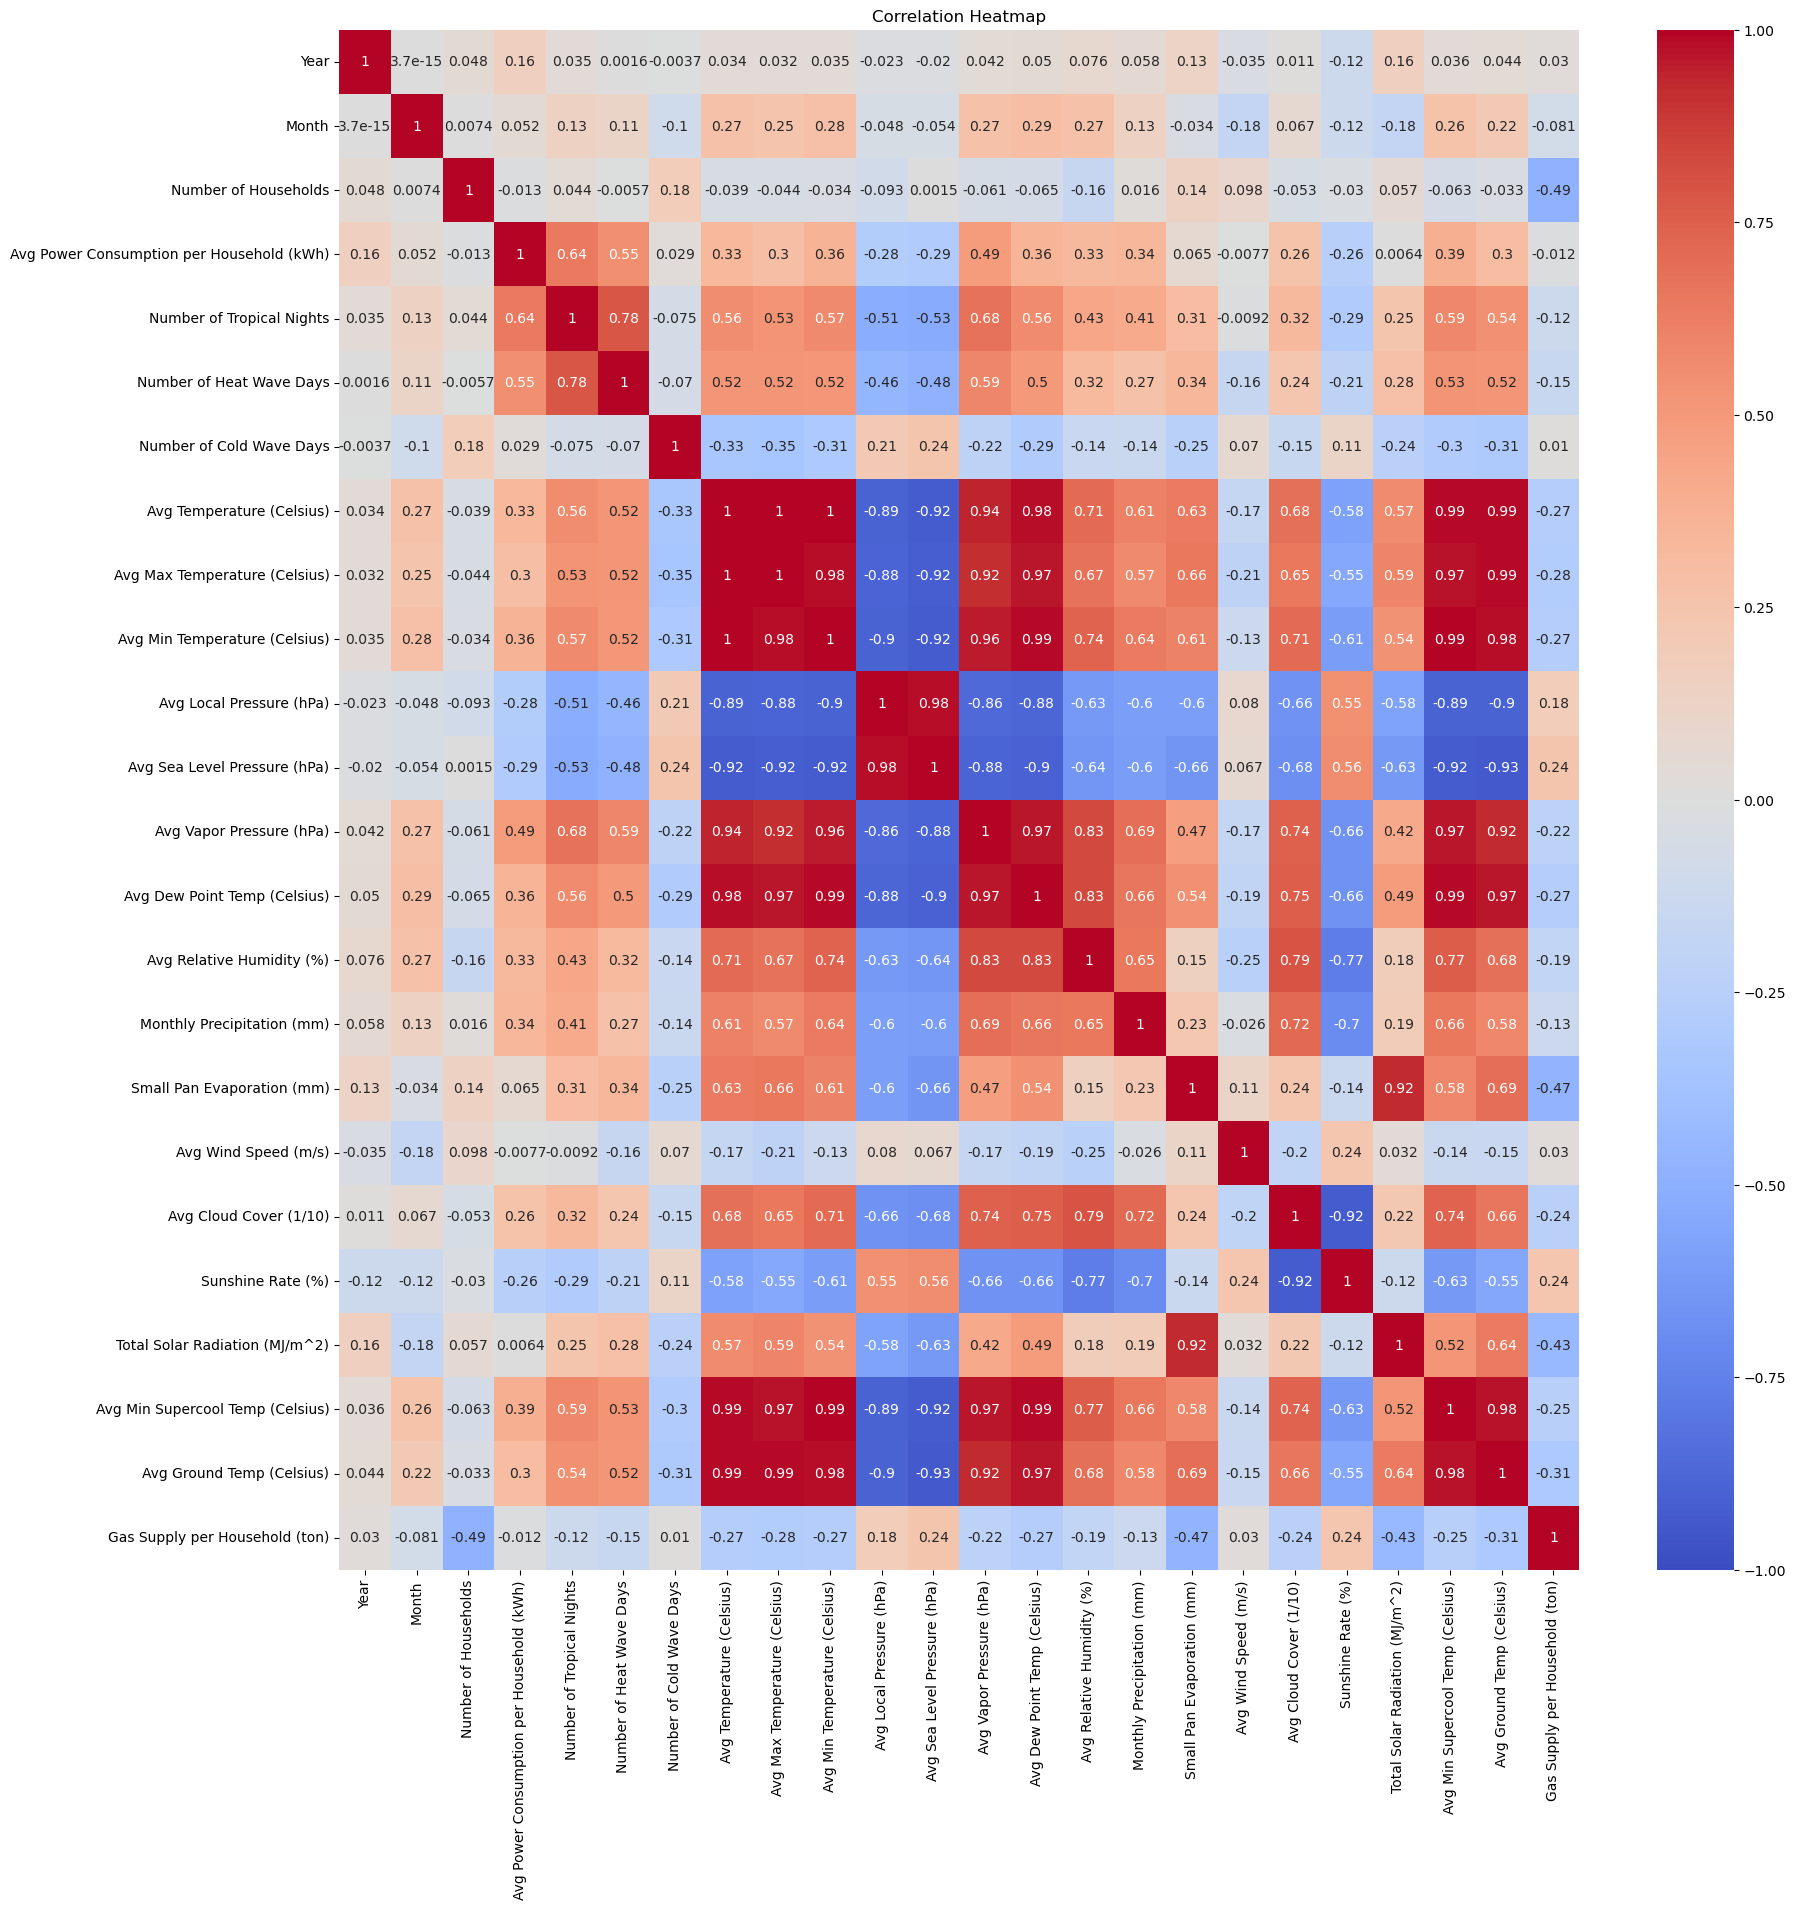

In [8]:
# Heatmap
df_numeric=df.select_dtypes(include=['number'])
df_corr=df_numeric.corr()
# df_corr_find = df_corr.copy()
# low_cols = df_corr_find[abs(df_corr_find['Avg Power Consumption per Household (kWh)'])<0.2].index
filter_corr=df_corr[abs(df_corr)>=0.1]
plt.figure(figsize=(20,20))
sns.heatmap(df_corr, annot=True,vmin=-1, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

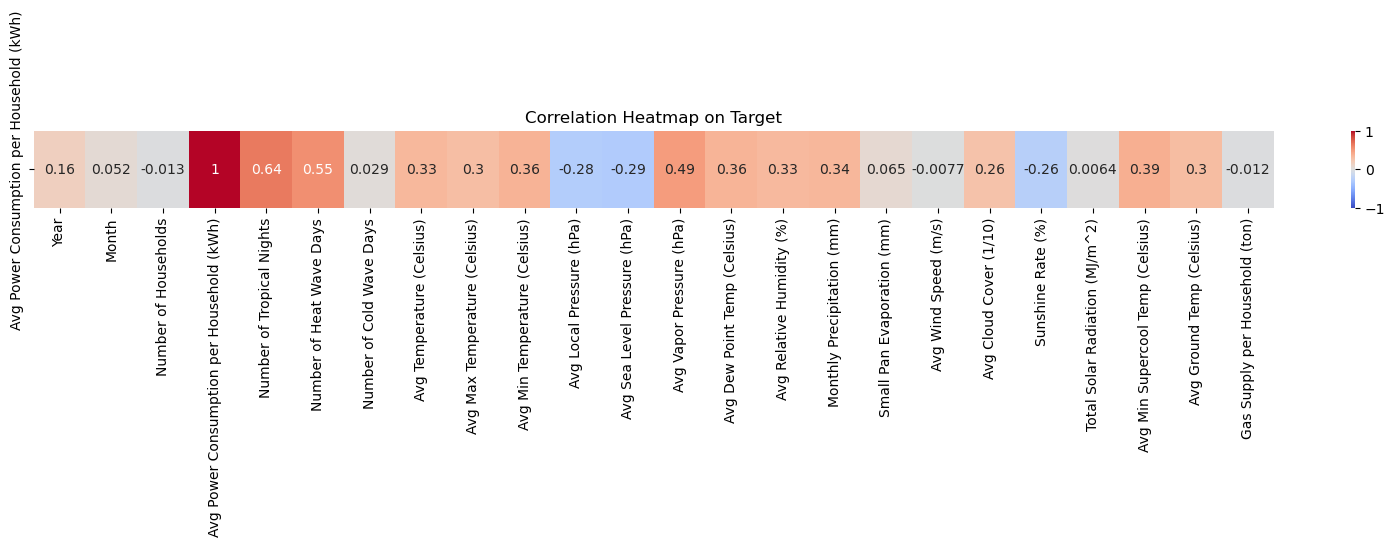

In [9]:
#heatmap
df_numeric=df.select_dtypes(include=['number'])
df_corr=df_numeric.corr()
# df_corr_find = df_corr.copy()
# low_cols = df_corr_find[abs(df_corr_find['Avg Power Consumption per Household (kWh)'])<0.2].index
df_corr=df_corr.loc[['Avg Power Consumption per Household (kWh)']]
#filter_corr=df_corr[abs(df_corr)>=0.1]
plt.figure(figsize=(20,1))
sns.heatmap(df_corr, annot=True,vmin=-1, cmap='coolwarm')
plt.title('Correlation Heatmap on Target')
plt.show()

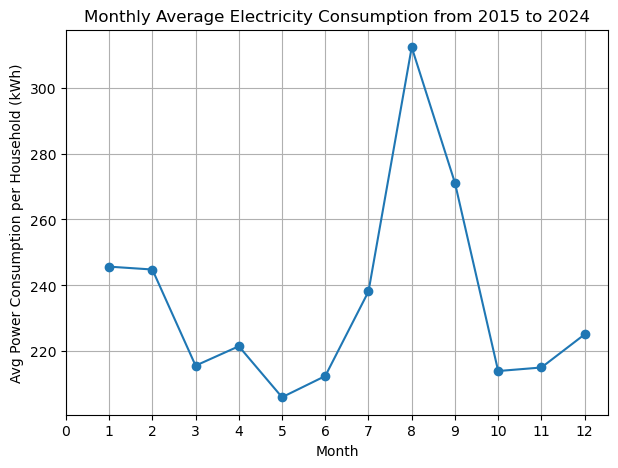

In [ ]:
# Monthly awaitvg electricity consumption

ele_plt = df.groupby('Month')['Avg Power Consumption per Household (kWh)'].mean()

plt.figure(figsize=(7, 5))
ele_plt.plot(kind='line', marker='o')
plt.title("Monthly Average Electricity Consumption from 2015 to 2024")
plt.xlabel("Month")
plt.ylabel("Avg Power Consumption per Household (kWh)")
plt.xticks(np.arange(0,13,1),rotation=0)
plt.grid()
plt.show()

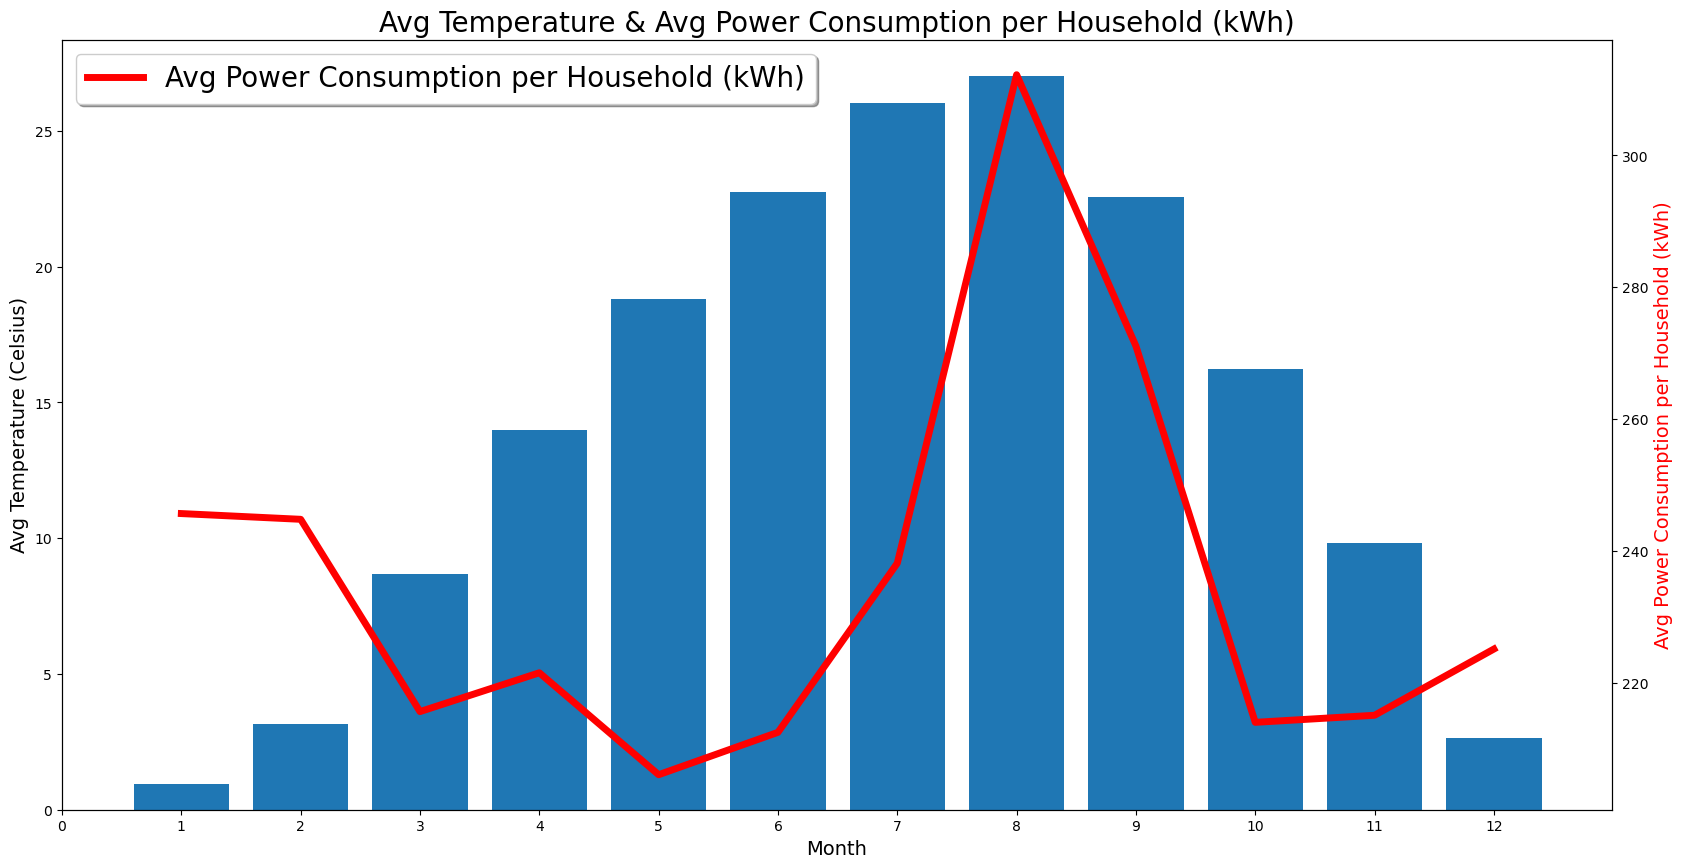

In [ ]:
# Monthly average electricity consumption + temperture

avg_t_mean = df.groupby('Month')['Avg Temperature (Celsius)'].mean()
avg_pc_mean = df.groupby('Month')['Avg Power Consumption per Household (kWh)'].mean()

fig = plt.figure(figsize=(20,10))
fig.set_facecolor('white') 
ax = fig.add_subplot()
 
ax.bar(avg_t_mean.index, avg_t_mean , label='Avg Temperature (Celsius)')
ax.set_ylabel('Avg Temperature (Celsius)', fontsize=14, color='black') 
ax.set_xlabel('Month', fontsize=14, color='black')
 
ax2 = ax.twinx()
ax2.set_ylabel('Avg Power Consumption per Household (kWh)', fontsize=14, color='red')
ax2.plot(avg_pc_mean.index ,avg_pc_mean, label='Avg Power Consumption per Household (kWh)',color='red', linewidth = 5)

plt.xticks(np.arange(0,13,1),rotation=0)
plt.title('Avg Temperature & Avg Power Consumption per Household (kWh)',fontsize=20)
plt.legend(loc = 2, fontsize=20, frameon=True, shadow=True)

plt.show()

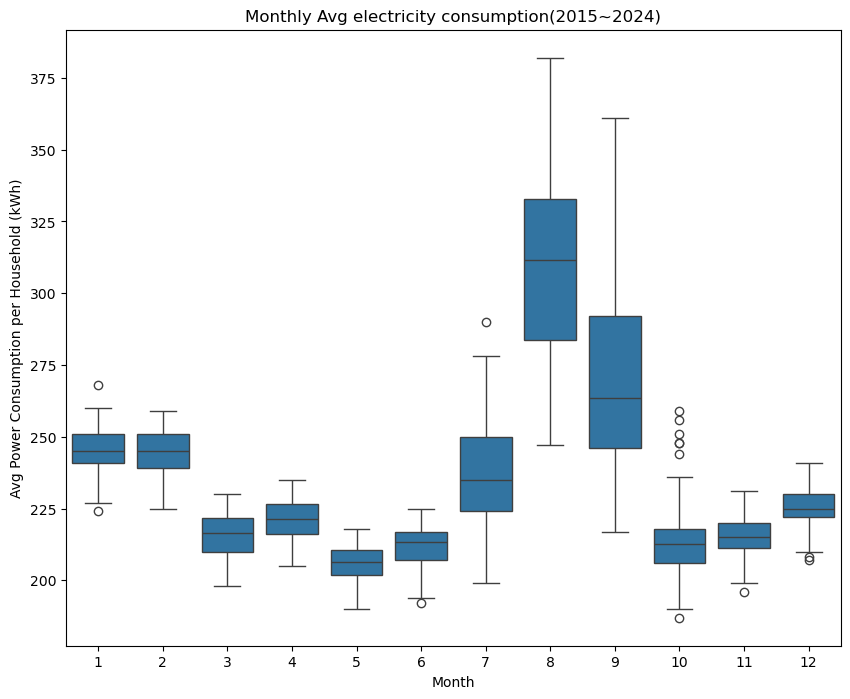

In [ ]:
# Monthly Avg electricity consumption boxplot

plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x='Month', y='Avg Power Consumption per Household (kWh)')
plt.title("Monthly Avg electricity consumption(2015~2024)")
plt.xlabel("Month")
plt.ylabel("Avg Power Consumption per Household (kWh)")
plt.show()

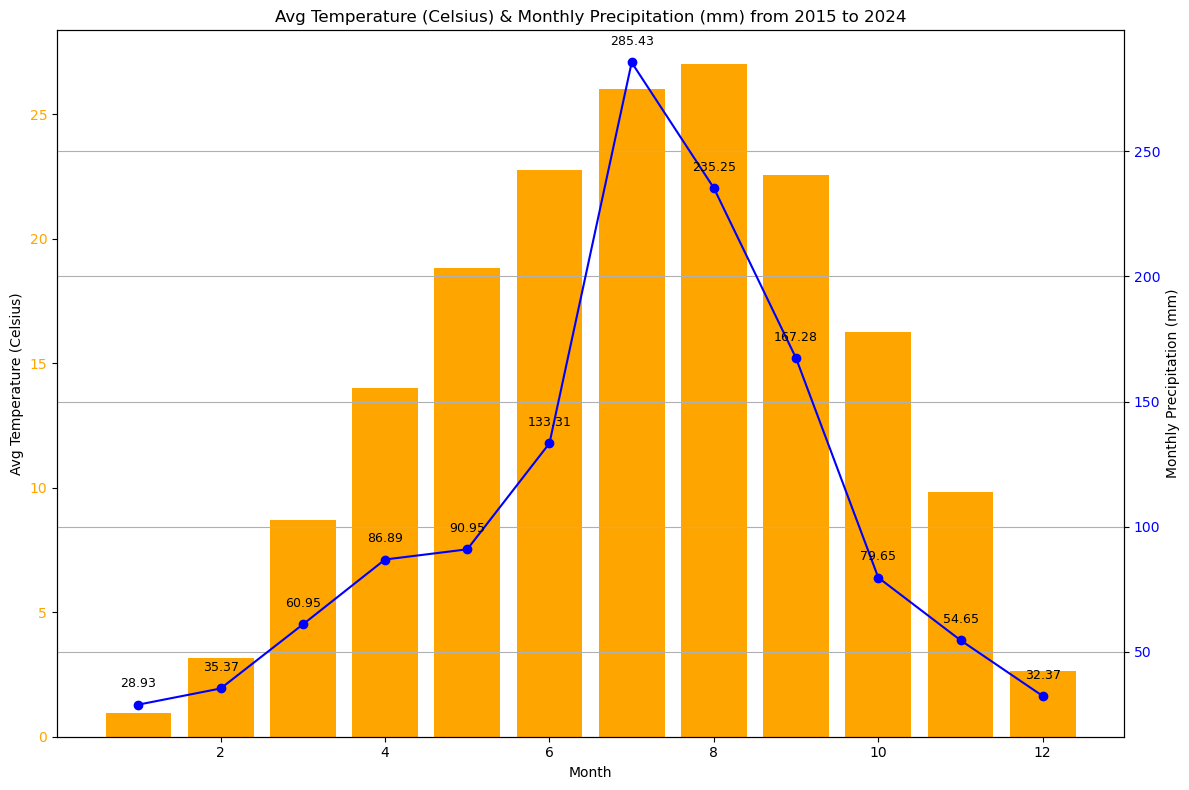

In [15]:
# Monthly temperature plot
dual_features_plot(a='Avg Temperature (Celsius)', b='Monthly Precipitation (mm)', c='Month')


In [ ]:
# # #Year per: 84 Month per: 70 Region per: 140 Total data:840
# 
# monthly_data = df.groupby('Region')['Avg Power Consumption per Household (kWh) Household (kWh)'].mean( ).reset_index()
# df_mean=df.groupby(['YeaAvg Power Consumption per Household (kWh)r Househol# d (kWh)']).mean()
# unstacked_df = df_mean.unst# ack(level='Year')
# fig, ax_1 = plt.subplot# s(figsize=(12, 8))
# ax_1.set# _xlabel('Region')
# ax_1.set_xticks# (monthly_data.indAvg Power Consumption per Household (kWh)on # per Household (kWh)')
# ax_1.plot(monthly_data['LocAvg Power Consumption per Household (kWh)'on per Household (kWh)'], color='orange',mark# er='o', ms=4,alpha=1)

# ax_1.tick_params(axis='# y', labelcolor='orange')
# ### #####
# ax_2 = ax_Small Pan Evaporation (mm)('S# mall Pan Evaporation (mm)')
# unstacked_df.plot(k# ind='bar',ax=ax_2,alpha=0.5)
# ax_2.tick_params(# axis='y', labelcolor='blue')

# plt.title(f'Avg Power Consumption per Household#  (kWh) from#  Region,Region'# )
# plt.grid()
# plt.tight_layout()
# for x_val,y_val in zip(monthly_data['Region'],monthly_data['Avg Power C# onsumption per Household (kWh)']):
# 	ax_1.text(x_val, y_val +0.1,f'{y_val:.2f}',ha='center',va='bottom'# ,fontsize=9,color='black',zorde# r=5)
# plt.subplots_adjust(right=1.8)
# plt.show()

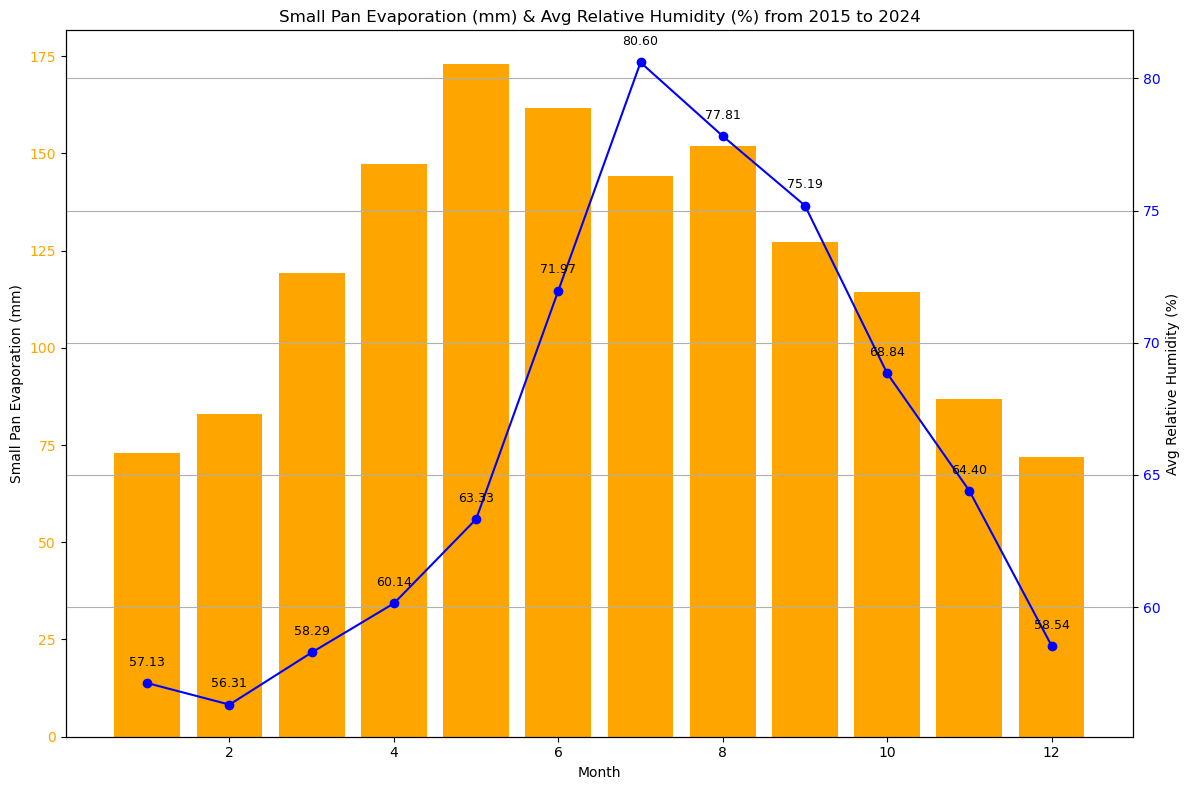

In [17]:
# Number of heatwave days and avg power consumption per household by year
dual_features_plot(a='Small Pan Evaporation (mm)',b='Avg Relative Humidity (%)',c='Month')

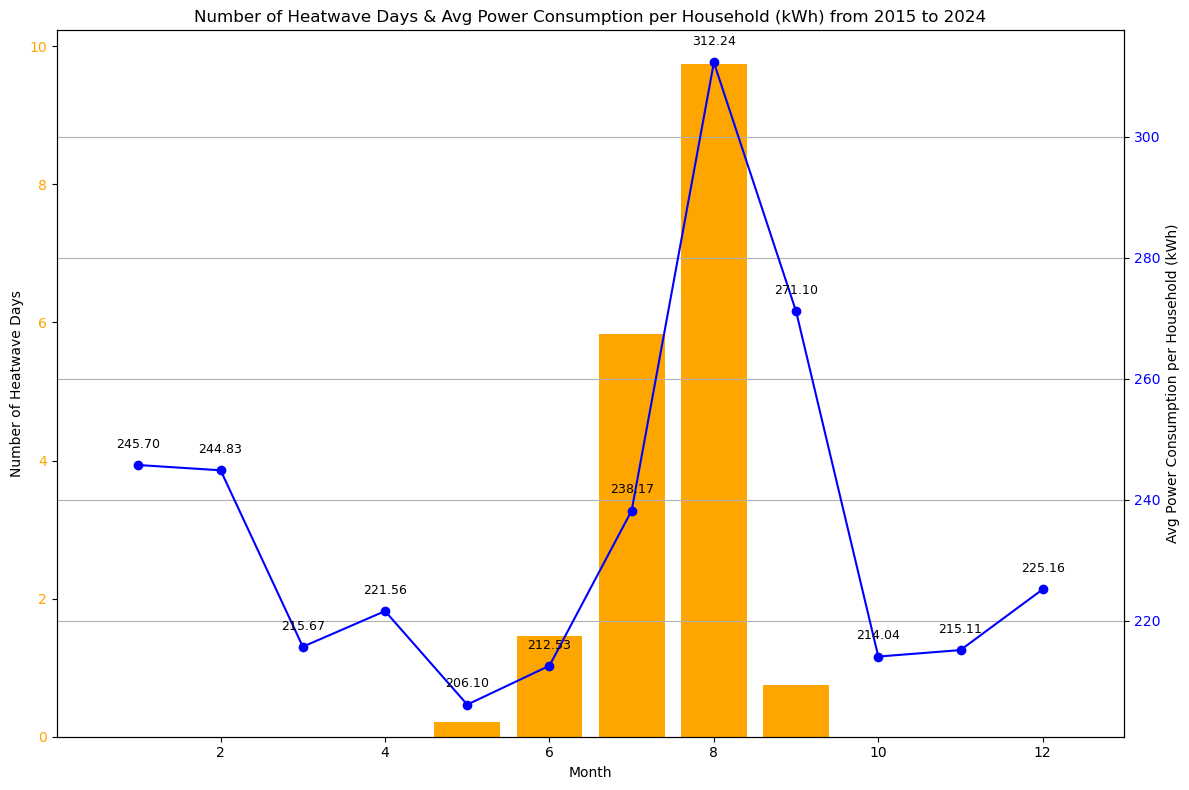

In [18]:
# Number of heatwave days and avg power consumption per household by year
dual_features_plot(a='Number of Heatwave Days',b='Avg Power Consumption per Household (kWh)',c='Month')


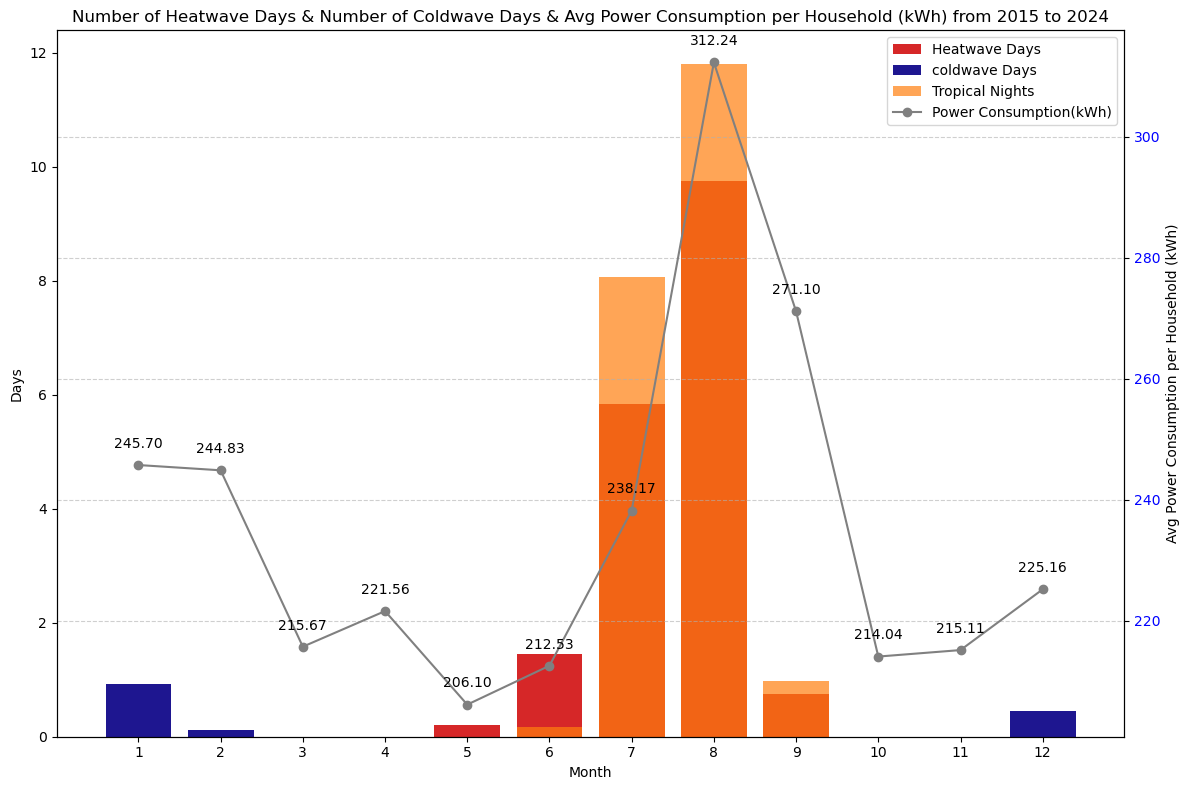

In [ ]:
bar_widths = 0.5
color_a = 'tab:red'
color_b = '#1e1690'
color_c = 'tab:orange'
col_a = 'Heatwave Days'
col_b = 'coldwave Days'
col_c = 'Tropical Nights'
data = df.groupby('Month')[['Number of Heatwave Days', 'Number of Coldwave Days','Number of Tropical Nights']].mean().reset_index()
data_mean = df.groupby('Month')[['Avg Power Consumption per Household (kWh)']].mean().reset_index()
fig, ax_1 = plt.subplots(figsize=(12, 8))
months = data['Month'].unique()
x = np.arange(len(months))
rects1 = ax_1.bar(data['Month'], data['Number of Heatwave Days'],label=col_a , color=color_a)
rects2 = ax_1.bar(data['Month'],  data['Number of Coldwave Days'],label=col_b, color=color_b)
rects3 = ax_1.bar(data['Month'],data['Number of Tropical Nights'],label=col_c,color=color_c,alpha=0.7)
ax_1.set_xticks(data['Month'])
ax_1.set_xlabel('Month')
ax_1.set_ylabel('Days')
ax_1.tick_params(axis='y', labelcolor='black')

#######
col_d = 'Power Consumption(kWh)'
ax_2 = ax_1.twinx()
ax_2.set_ylabel('Avg Power Consumption per Household (kWh)')
plot_c=ax_2.plot(data_mean['Month'], data_mean['Avg Power Consumption per Household (kWh)'], marker='o', color='grey',label=col_d )
ax_2.tick_params(axis='y', labelcolor='blue')
for x_val,y_val in zip(data_mean['Month'],data_mean['Avg Power Consumption per Household (kWh)']):
	ax_2.text(x_val, y_val +(ax_2.get_ylim()[1] - ax_2.get_ylim()[0]) * 0.02,f'{y_val:.2f}',ha='center',va='bottom',fontsize=10,color='black')
plt.title(f'Number of Heatwave Days & Number of Coldwave Days & Avg Power Consumption per Household (kWh) from 2015 to 2024')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.tight_layout()
handles_to_combine = [rects1, rects2,rects3] + plot_c
labels_to_combine = [h.get_label() for h in handles_to_combine]
h1,l1 =ax_1.get_legend_handles_labels()
h2,l2 =ax_2.get_legend_handles_labels()
handles = h1 + h2
labels = l1 + l2
plt.legend(handles,labels,loc='best')
plt.show()

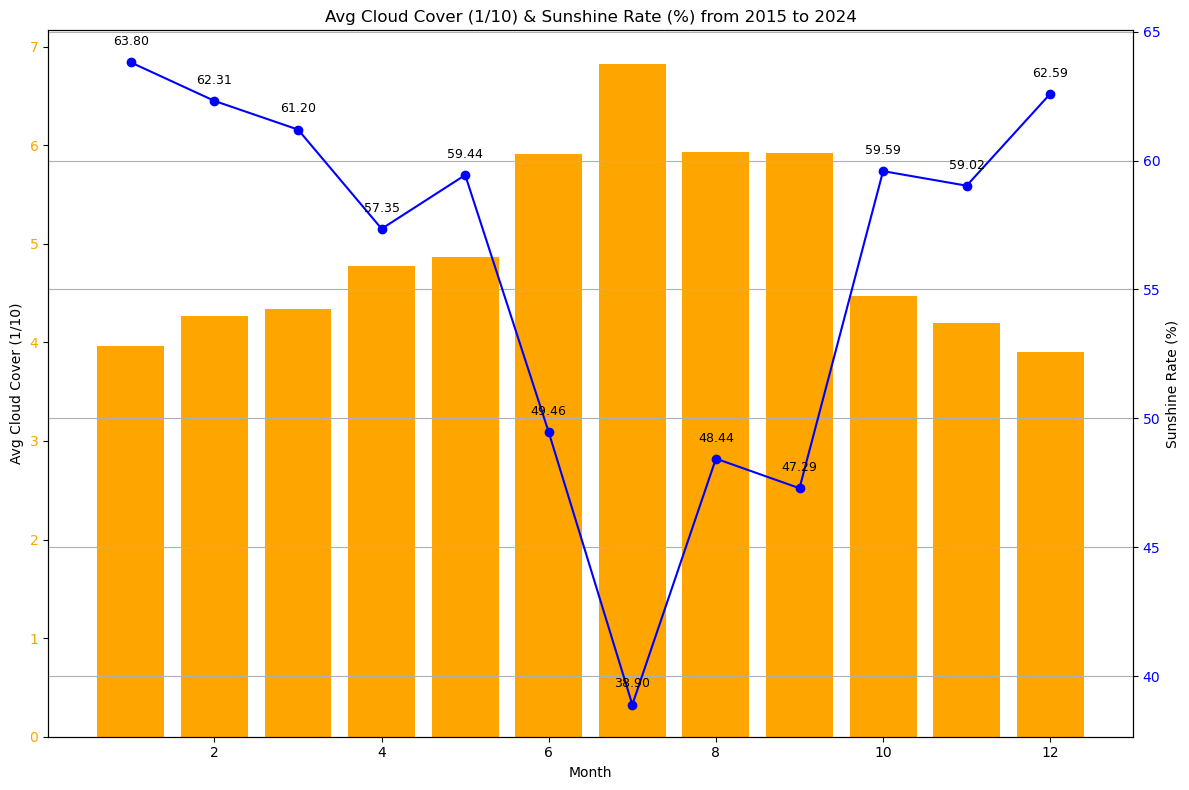

In [20]:
# Sunshine and avg cloud cover by month
# dual_features_plot(a='Sunshine Rate (%)', b='Avg Cloud Cover (1/10)', c='Month')
dual_features_plot(a='Avg Cloud Cover (1/10)', b='Sunshine Rate (%)', c='Month')

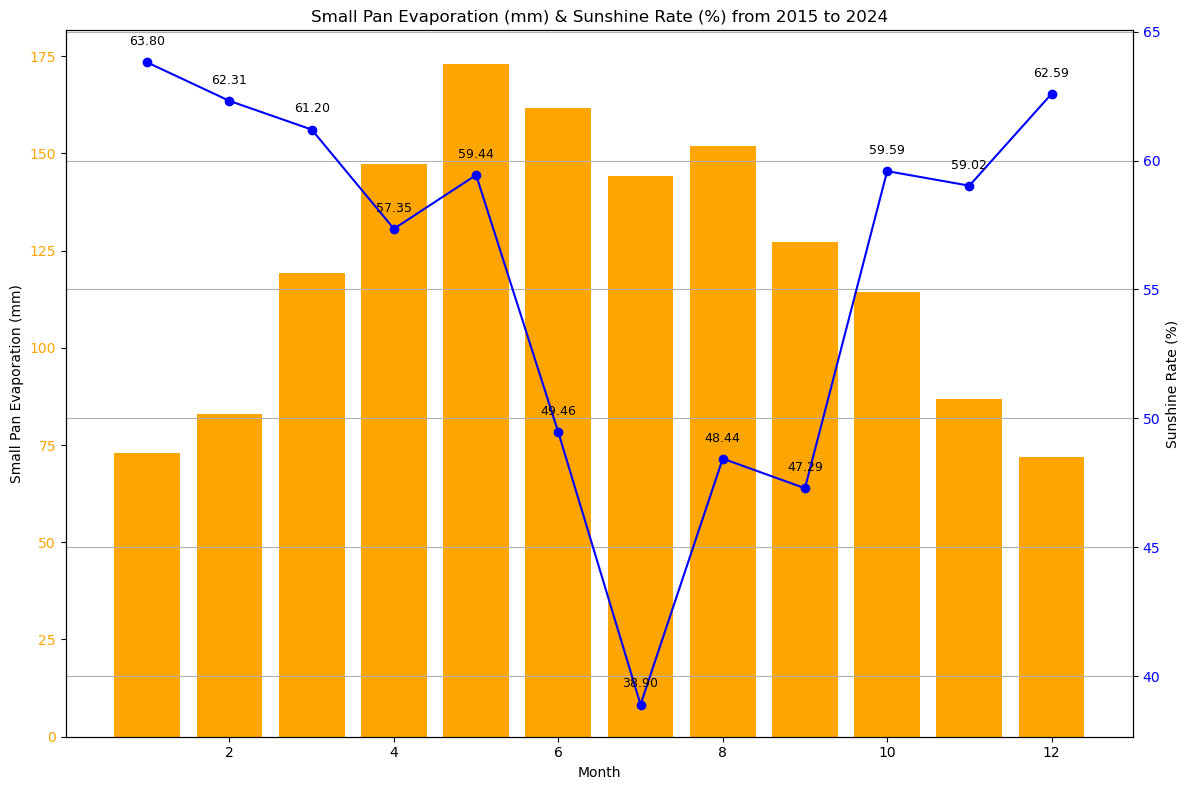

In [21]:
#Monthly sunlight and evaporation
# dual_features_plot(a='Sunshine Rate (%)', b='Small Pan Evaporation (mm)', c='Month')

dual_features_plot(a='Small Pan Evaporation (mm)', b='Sunshine Rate (%)', c='Month')

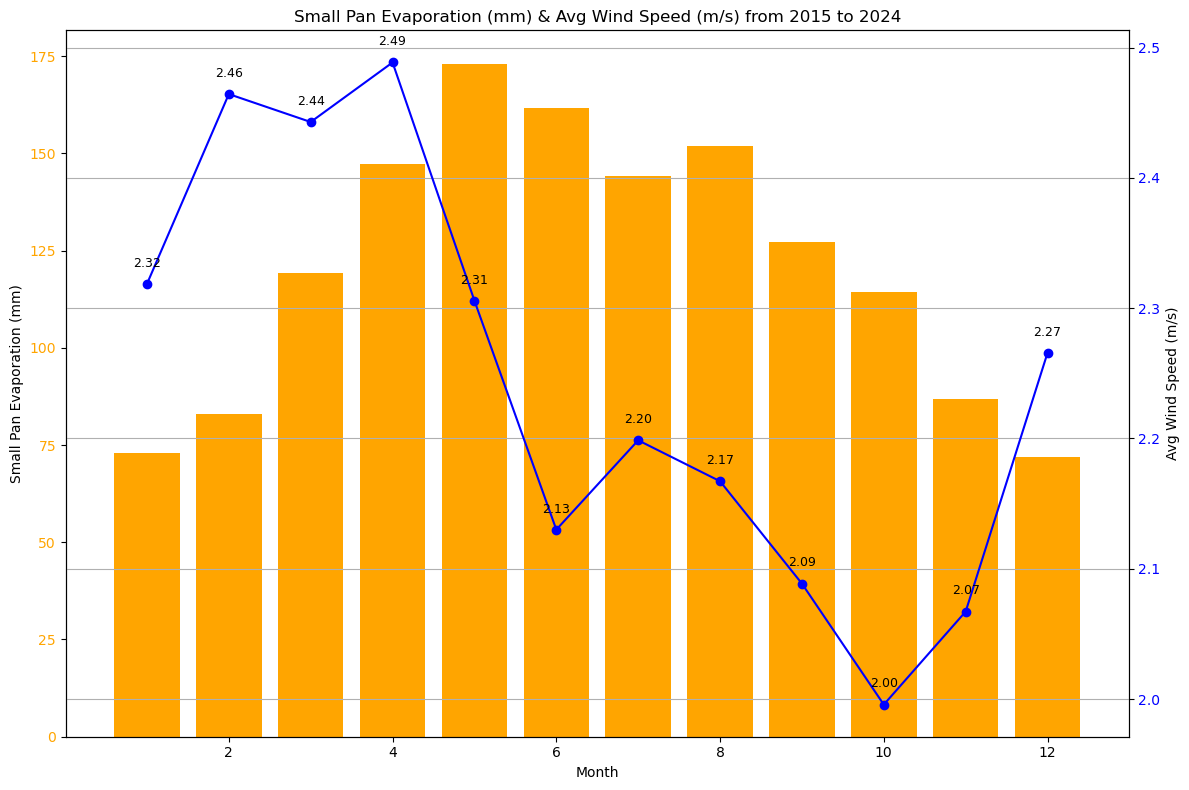

In [22]:
#Monthly Avg Wind Speed and evaporation
# dual_features_plot(a='Avg Wind Speed (m/s)', b='Small Pan Evaporation (mm)', c='Month')

dual_features_plot(a='Small Pan Evaporation (mm)', b='Avg Wind Speed (m/s)', c='Month')

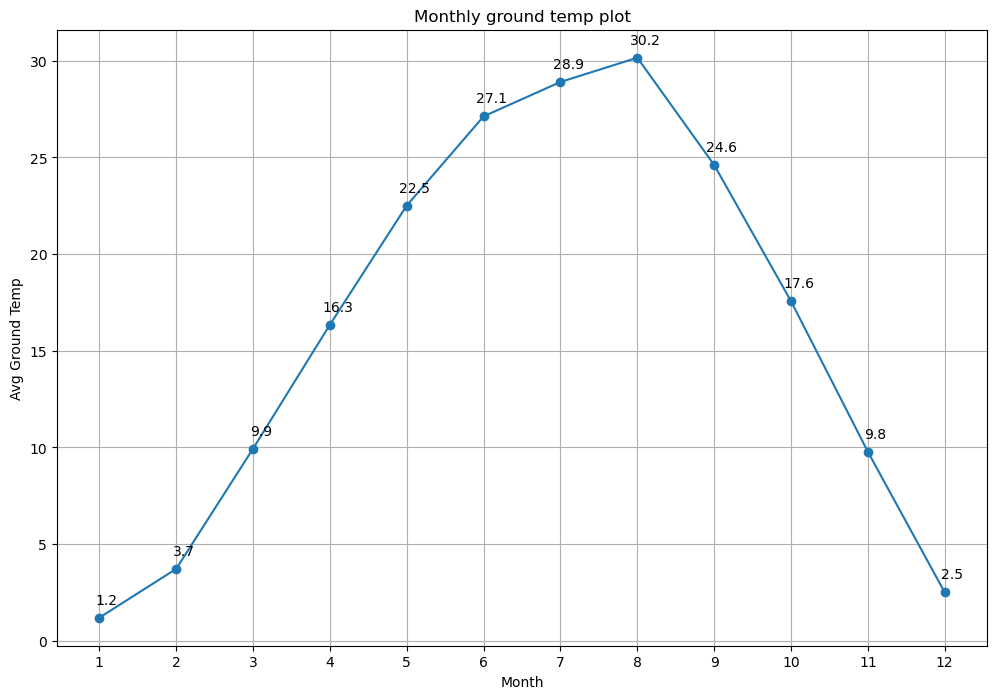

In [ ]:
# Monthly ground temp plot(month)
df=df.copy()
#Avg Ground Temp (Celsius)  
df_sum=df.groupby('Month')['Avg Ground Temp (Celsius)'].sum()
df_mean=df.groupby('Month')['Avg Ground Temp (Celsius)'].mean()
plt.figure(figsize=(12, 8))
df_mean.plot(kind='line',marker='o')
plt.xticks(df_mean.index)
plt.xlabel('Month')
plt.ylabel('Avg Ground Temp')
plt.title('Monthly ground temp plot')
for x_val, y_val in df_mean.items():
	plt.text(x_val+0.1,y_val+0.55,f'{y_val:.1f}',ha='center',va='bottom',fontsize=10)
plt.grid()
plt.show()

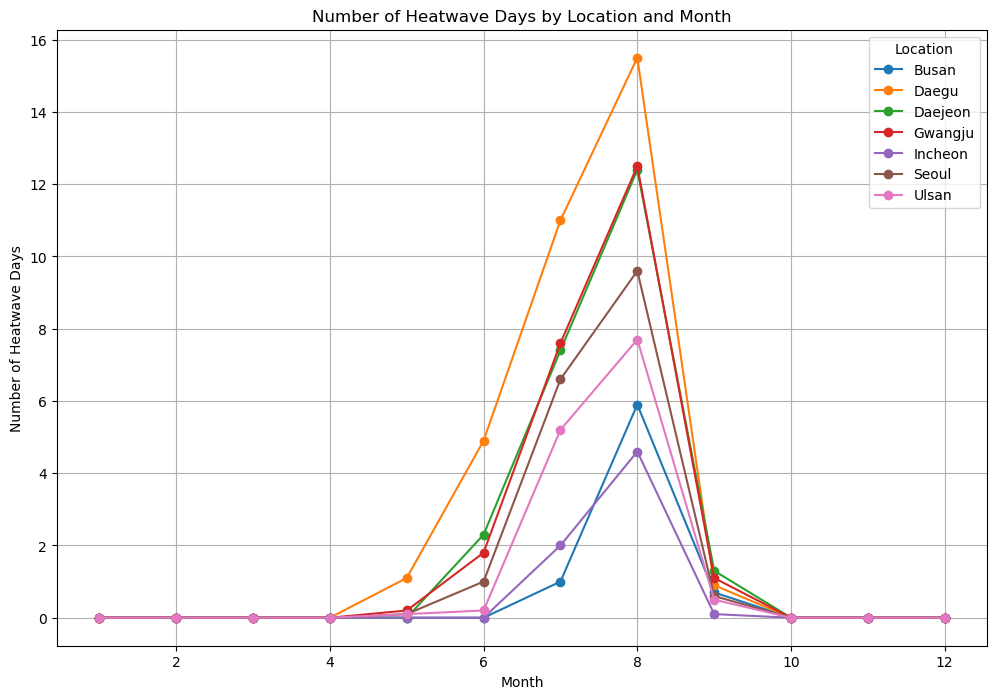

In [ ]:
one_feature_two_group('Region','Month','Number of Heatwave Days')

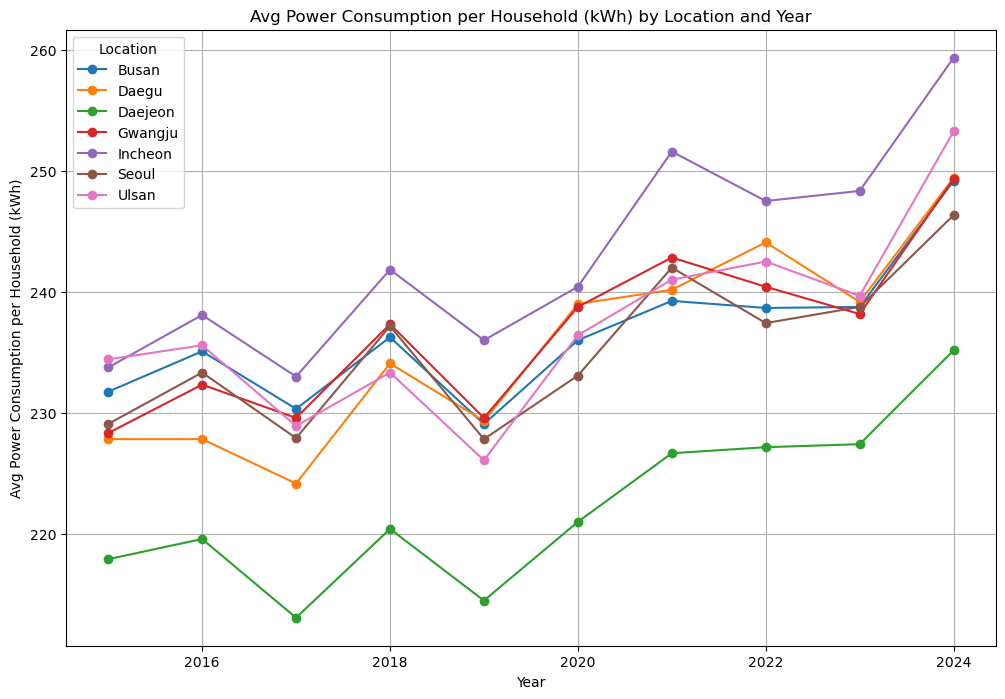

In [ ]:
one_feature_two_group('Region','Year','Avg Power Consumption per Household (kWh)')

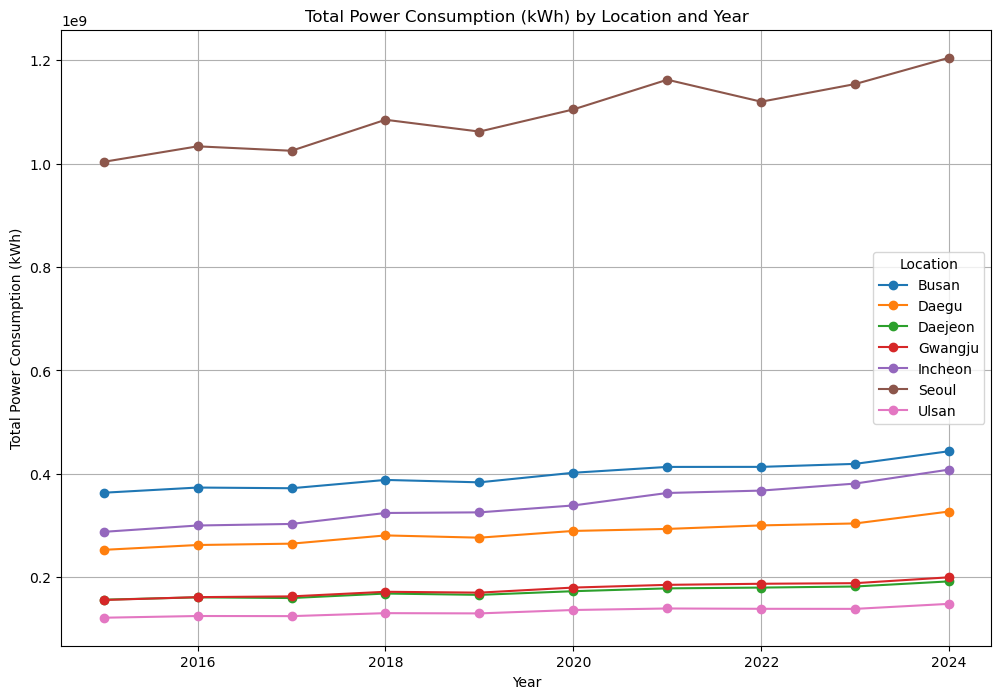

In [ ]:
df['Total Power Consumption (kWh)'] = df['Number of Households'] * df['Avg Power Consumption per Household (kWh)']
one_feature_two_group('Region','Year','Total Power Consumption (kWh)')
df = df.drop(columns=['Total Power Consumption (kWh)'])

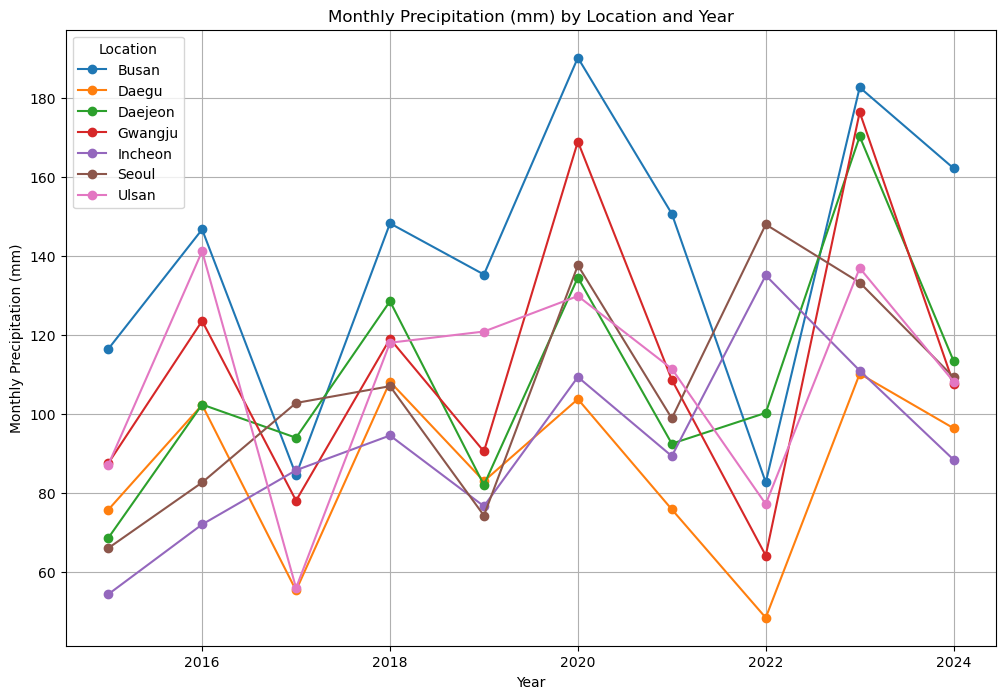

In [ ]:
# Precipitation by Region

one_feature_two_group('Region','Year','Monthly Precipitation (mm)')

### **Data Preprocessing**

- Preprocessing steps safe to do before splitting
<br>

	- Remove obvious duplicates
	- Fix incorrect labels
	- Drop irrelevant columns
	- Basic data cleaning such as fixing typos or unifying units
	- Handling missing data if not based on global statistics such as dropping rows w/ missing target
	- Changing boolean type to 0 / 1
</br>

- Preprocessing steps that should happen after train-test split
<br>
	- Feature scaling / Normalisation
	- Encoding categorical variables
	- Dimensionality reduction
	- Outlier detection (if model is sensitive)
	- Feature selection based on correlation or variance
	- Creating time-based features if it involves future data
	- Data augmentation
</br>

In [16]:
# Data split for features and target
X = df.drop(columns=['Avg Power Consumption per Household (kWh)'])
y = df['Avg Power Consumption per Household (kWh)']

In [18]:
# Grab column names of each data type
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
datetime_cols = X.select_dtypes(include=['datetime']).columns
target_col = y.name

In [19]:
# Data split for train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Region label encoding
# label_encoder = LabelEncoder()
# for col in categorical_cols:
#     X_train[col] = label_encoder.fit_transform(X_train[col])
#     X_test[col] = label_encoder.transform(X_test[col])

# Region one hot encoding
X_train = pd.get_dummies(data=X_train, columns=['Region'], dtype=int)
X_test = pd.get_dummies(data=X_test, columns=['Region'], dtype=int)

# Scaling
scaler=StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


In [33]:
# Check multicolinearity using VIF on training data
df_vif = pd.DataFrame()
df_vif['feature'] = X_train.columns
df_vif['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
df_vif

,feature,VIF
0,Year,3.994718
1,Month,2.435689
2,Number of Households,903.007744
3,Avg Electricity Btill per Household (KRW),1.706694
4,Number of Tropical Nights,5.443858
5,Number of Heatwave Days,4.157084
6,Number of Coldwave Days,1.463889
7,Avg Temperature (Celsius),6704.435120
8,Avg Max Temperature (Celsius),1579.991605
9,Avg Min Temperature (Celsius),2090.334131


In [34]:
# Drop columns w/ high VIF
# X_train = X_train.drop(columns=['Avg Temperature (Celsius)', 'Avg Dew Point Temp (Celsius)', 'Avg Min Surface Temp (Celsius)'])
# X_test = X_test.drop(columns=['Avg Temperature (Celsius)', 'Avg Dew Point Temp (Celsius)', 'Avg Min Surface Temp (Celsius)'])

# # Re-check multicolinearity
# df_vif_removed = pd.DataFrame()
# df_vif_removed['feature'] = X_train.columns
# df_vif_removed['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
# df_vif_removed

In [35]:
# PCA
pca = PCA()
pca.fit_transform(X_train)

# Find the features that contributes the most to PC 1 and PC 2 
weights_pca = abs(pca.components_)
top_pc1_idx = np.argsort(weights_pca[0])[::-1][:15]
top_pc1_name = [X_train.columns[i] for i in top_pc1_idx]

# Grab features that contribute to PC 1 and PC 2
top_features = list(set(top_pc1_name))
pca_corr = X_train[top_features].corrwith(y_train)
pca_corr

# Drop columns w/ low contributions to PC 1
X_train_pca = X_train[top_features]
X_test_pca = X_test[top_features]

### **Modelling**

Run different machine learning models w/ hyperparameter tunings. <br>
Comparison of errors using RMSE, MAE, R^2 , and adjusted R^2. <br>
R^2 always increases when there are more features, so adjusted R^2 will penalise that impact.

In [20]:
def adj_r2_score(y_true: pd.Series, y_pred: pd.Series, X_features: pd.DataFrame) -> float:
	"""
	Compute the Adjusted R² (coefficient of determination).

	Adjusted R² adjusts the regular R² score for the number of predictors (features)
	in the model. It penalizes the R² score for adding unnecessary predictors, helping
	to avoid overfitting.

	Parameters:
	- y_true : array-like of shape (n_samples,)
		True target values.
	- y_pred : array-like of shape (n_samples,)
		Predicted target values from the model.
	- X_features : array-like of shape (n_samples, n_features)
		Data used for getting the number of predictors (features) used in the model.

	Returns:
	- adj_r2 : float
		The adjusted R-squared score. Returns NaN if the number of predictors is too large
		for the formula to be valid (i.e., n <= p + 1).
	"""
	n = len(y_true)
	p = X_features.shape[1]
	
	# Prevent division by zero or negative denominator
	if n <= p + 1:
		warnings.warn("Adjust R^2 is undefined.")
		return float('nan')
	
	return 1 - (1 - r2_score(y_true, y_pred)) * (n - 1) / (n - p - 1)

In [21]:
# Linear regression
start_time = time.time()
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
end_time = time.time()
training_time_lr = end_time - start_time
print(f'Training time: {training_time_lr}')

Training time: 0.005348920822143555


In [40]:
# Elastic net
hyperparams_en = {'alpha': [0.1, 1, 10],
				  'l1_ratio': [0.1, 0.5, 0.9]}
start_time = time.time()
model_en = GridSearchCV(estimator=ElasticNet(), 
								 param_grid=hyperparams_en, 
								 cv=5)
model_en.fit(X_train, y_train)
end_time = time.time()
training_time_en = end_time - start_time
print(f'Training time: {training_time_en}')


Training time: 0.1811690330505371


In [42]:
# SVR
hyperparams_svr = {'kernel': ['poly', 'rbf', 'sigmoid'],
				   'C':[10, 100, 1000],
				   'epsilon':[0.3,0.5,0.8]}
start_time = time.time()
model_svr = GridSearchCV(estimator=SVR(),
			 			 param_grid=hyperparams_svr,
			 			 cv=5)
model_svr.fit(X_train, y_train)
end_time = time.time()
training_time_svr = end_time - start_time
print(f'Training time: {training_time_svr}')

Training time: 3.7875359058380127


In [45]:
# Decision tree
hyperparams_dt = {'criterion': ['absolute_error', 'squared_error'],
				  'max_depth': [3, 5, 7, 10, None],
				  'min_samples_split': [2, 5, 10, 20],
				  'min_samples_leaf': [1, 2, 4],
				  'max_features': ['sqrt', 'log2', None]}
start_time = time.time()
model_dt = GridSearchCV(estimator=DecisionTreeRegressor(),
						param_grid = hyperparams_dt,
						cv=5)
model_dt.fit(X_train,y_train)
end_time = time.time()
training_time_dt = end_time - start_time
print(f'Training time: {training_time_dt}')

Training time: 13.644085884094238


In [51]:
# Random Forest
hyperparams_rf = {'n_estimators': [10, 50, 100],
				  'max_depth': [None, 10, 20, 30],
				  'min_samples_split': [2, 5, 10], 
				  'min_samples_leaf': [1, 2, 4],
				  'max_features': [None, 'sqrt', 'log2', 0.5],
				  'bootstrap': [True, False],}  
start_time = time.time()
model_rf = GridSearchCV(estimator=RandomForestRegressor(),
						param_grid=hyperparams_rf,
						cv=5)
model_rf.fit(X_train,y_train)
end_time = time.time()
training_time_rf = end_time - start_time
print(f'Training time: {training_time_rf}')


Training time: 383.64093017578125


In [52]:
# Ada
hyperparams_ada = {'n_estimators': [30,50,100],
				   'learning_rate': [0.001, 0.01, 0.1]}
start_time = time.time()
model_ada = GridSearchCV(estimator=AdaBoostRegressor(),
						 param_grid=hyperparams_ada,
						 cv=5)
model_ada.fit(X_train,y_train)
end_time = time.time()
training_time_ada = end_time - start_time
print(f'Training time: {training_time_ada}')

Training time: 4.555315017700195


In [ ]:
# XGBRegressor
hyperparams_xgb = {'n_estimators': [100, 300, 500],
				   'learning_rate': [0.01, 0.05, 0.1],
				   'max_depth': [3, 5, 7]}
start_time = time.time()
model_xgb = GridSearchCV(estimator=XGBRegressor(),
						 param_grid=hyperparams_xgb,
						 cv=5,
						 verbose=0)
model_xgb.fit(X_train,y_train)
end_time = time.time()
training_time_xgb = end_time - start_time
print(f'Training time: {training_time_xgb}')

Training time: 40.06518292427063


In [55]:
# Stacking
# Training
start_time = time.time()
base_learners = [('Elastic net', model_en.best_estimator_), 
				 ('SVR', model_svr.best_estimator_), 
				 ('RandomForest', model_rf.best_estimator_),
				 ('DecisionTree', model_dt.best_estimator_)]
meta_learner = model_xgb.best_estimator_
model_stacking = StackingRegressor(estimators=base_learners,
								   final_estimator=meta_learner,
								   cv=5)
model_stacking.fit(X_train, y_train)
end_time = time.time()
training_time_stacking = end_time - start_time
print(f'Training time: {training_time_stacking}')


Training time: 1.4507381916046143


In [56]:
def evaluation(models: List[Union[GridSearchCV, BaseEstimator]], X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series) -> pd.DataFrame:
	"""
    Evaluates a list of models (either GridSearchCV objects or regular estimators)
    on training and test data, and returns a summary DataFrame of evaluation metrics.

    Parameters:
        models (List[Union[GridSearchCV, BaseEstimator]]): List of models to evaluate.
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training labels.
        y_test (pd.Series): Testing labels.

    Returns:
        pd.DataFrame: A summary table with model name, evaluation metrics,
                      training time, and best hyperparameters (if available).
    """
	results = []
	for model in models:
		# Check if a model is a GridSearchCV object
		if isinstance(model, GridSearchCV):
			best_model = model.best_estimator_
			best_hyperparams = model.best_params_
		else:
			best_model = model
			best_hyperparams = 'N/A'
		model_name = str(best_model).split('(')[0]
		
		# Training
		start_time = time.time()
		best_model.fit(X_train, y_train)
		end_time = time.time()
		training_time = end_time - start_time
		
		# Testing
		y_pred = model.predict(X_test)
		
		# Evaluation
		mae = mean_absolute_error(y_test,y_pred)
		mse = mean_squared_error(y_test, y_pred)
		rmse = np.sqrt(mse)
		r2 = r2_score(y_test,y_pred)
		adj_r2 = adj_r2_score(y_test,y_pred,X_test)
		
		# Result dataframe
		result = pd.DataFrame({'Model': model_name,
							   'MAE': mae,
							   'RMSE': rmse,
							   'R^2': r2,
							   'Adj-R^2' : adj_r2,
							   'Training time': training_time,
							   'Best hyperparameters': [best_hyperparams]})
		results.append(result)
		
	# Sort results by Model
	results = pd.concat(results).sort_values(by=['Model'])
	pd.options.display.float_format = '{:.2f}'.format

	return results

models = [model_lr, model_en, model_dt, model_svr, model_rf, model_ada, model_xgb, model_stacking]
results = evaluation(models=models, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
results

,Model,MAE,RMSE,R^2,Adj-R^2,Training time,Best hyperparameters
0,AdaBoostRegressor,8.68,12.18,0.87,0.83,0.17,"{'learning_rate': 0.1, 'n_estimators': 100}"
0,DecisionTreeRegressor,8.79,16.99,0.75,0.67,0.01,"{'criterion': 'squared_error', 'max_depth': 10..."
0,ElasticNet,14.79,20.84,0.62,0.51,0.02,"{'alpha': 0.1, 'l1_ratio': 0.9}"
0,LinearRegression,14.78,20.99,0.61,0.50,0.00,N/A
0,RandomForestRegressor,6.48,12.93,0.85,0.81,0.14,"{'bootstrap': False, 'max_depth': 30, 'max_fea..."
0,SVR,9.16,15.70,0.78,0.72,0.08,"{'C': 1000, 'epsilon': 0.5, 'kernel': 'rbf'}"
0,StackingRegressor,6.94,12.40,0.87,0.83,1.43,N/A
0,XGBRegressor,5.56,10.58,0.90,0.87,0.46,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


### **Neural Network**

**Root cause of overfitting / accuracy drop**
1. Model complexity is too high for the dataset size
2. Learning rate / optimizer
3. No regularisation
4. No early stopping
5. Class imbalance
6. Feature scaling / input issues

**Ways to fix**
1. Add dropout layer
2. Switch optimizer
3. Add regularisation
4. Add early stopping
5. Check class imbalance
6. Normalise / Standardise input features

In [ ]:
y_scale=StandardScaler()
y_train=y_scale.fit_transform(y_train)
y_test=y_scale.transform(y_test)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [ ]:

##NN start_time
import tensorflow as tf

seed=42
random.seed(seed)
np.random.seed(seed)
# random.seed(seedtf.random.set_seed(seed))
tf.random.set_seed(seed)


start_time = time.time()
# NN
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = keras.Sequential([
	keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
	keras.layers.Dense(32, activation='relu'),
	keras.layers.Dense(16, activation='relu'),
	keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=100, batch_size=64,
					validation_data=(X_valid, y_valid), verbose=1)

y_pred_NN = model.predict(X_test)
y_pred_NN = y_scale.inverse_transform(y_pred_NN).flatten()
y_test_inverse = y_scale.inverse_transform(y_test).flatten()

mae_NN = mean_absolute_error(y_true=y_test_inverse, y_pred=y_pred_NN)
rmse_NN = np.sqrt(mean_squared_error(y_true=y_test_inverse, y_pred=y_pred_NN))
r2 = r2_score(y_true=y_test_inverse, y_pred=y_pred_NN)
adj_r2_NN = adj_r2_score(y_true=y_test_inverse, y_pred=y_pred_NN, X_features=X_test)

end_time = time.time()

print(f"Training time: {end_time - start_time: .4f} \n")
print(f"R-squared (R²): {r2} \n")
print(f"adjR-squared (R²): {adj_r2_NN} \n")
print(f"mae_NN : {mae_NN} \n")
print(f"rmse_NN: {rmse_NN} \n")

Epoch 1/100


/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9211 - val_loss: 0.3784
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5585 - val_loss: 0.3199
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3794 - val_loss: 0.2071
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2658 - val_loss: 0.1836
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2043 - val_loss: 0.1484
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1723 - val_loss: 0.1277
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1512 - val_loss: 0.1097
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1326 - val_loss: 0.0963
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1186 - val_loss: 0.0891
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1076 - val_loss: 0.0871
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0977 - val_loss: 0.0863
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0894 - val_l

KeyboardInterrupt: 

In [ ]:

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:

##NN 준언 수정본
y_scale=StandardScaler()
# 스케일링 전에 y_train을 2차원 배열로 변환합니다.
y_train_2d = y_train.values.reshape(-1, 1)  
y_train_scaled = y_scale.fit_transform(y_train_2d)  
# 스케일링 전에 y_test를 2차원 배열로 변환합니다.
y_test_2d = y_test.values.reshape(-1, 1)  
y_test_scaled = y_scale.transform(y_test_2d)  
# 모델에서 필요한 경우 스케일링 후 y_train_scaled와 y_test_scaled를 다시 1차원으로 변환해야 할 수 있습니다.
y_train_scaled = y_train_scaled.flatten()
y_test_scaled = y_test_scaled.flatten()

import tensorflow as tf

seed=42
random.seed(seed)
np.random.seed(seed)
# random.seed(seedtf.random.set_seed(seed))
tf.random.set_seed(seed)



start_time = time.time()
# NN
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = keras.Sequential([
	keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
	keras.layers.Dense(32, activation='relu'),
	keras.layers.Dense(16, activation='relu'),
	keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=200, batch_size=16,
					validation_data=(X_valid, y_valid), verbose=1)

y_pred_NN = model.predict(X_test)
y_pred_NN = y_scale.inverse_transform(y_pred_NN).flatten()
y_test_inverse = y_scale.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

mae_NN = mean_absolute_error(y_true=y_test_inverse, y_pred=y_pred_NN)
rmse_NN = np.sqrt(mean_squared_error(y_true=y_test_inverse, y_pred=y_pred_NN))
r2 = r2_score(y_true=y_test_inverse, y_pred=y_pred_NN)
adj_r2_NN = adj_r2_score(y_true=y_test_inverse, y_pred=y_pred_NN,X_features=X_test)

end_time = time.time()

print(f"Training time: {end_time - start_time: .4f} \n")
print(f"R-squared (R²): {r2} \n")
print(f"adjR-squared (R²): {adj_r2_NN} \n")
print(f"mae_NN : {mae_NN} \n")
print(f"rmse_NN: {rmse_NN} \n")

Epoch 1/200


/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 55568.6523 - val_loss: 50517.5430
Epoch 2/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46128.1953 - val_loss: 21617.8789
Epoch 3/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13406.3643 - val_loss: 4989.6470
Epoch 4/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4137.2173 - val_loss: 3510.7380
Epoch 5/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2699.9441 - val_loss: 2402.1626
Epoch 6/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1832.7817 - val_loss: 1668.1509
Epoch 7/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1309.3662 - val_loss: 1223.4900
Epoch 8/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 990.5529 - val_loss: 945.0893
Epoch 9/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 781.1205 - val_loss: 763.6482
Epoch 10/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 641.0792 - val_loss: 642.5725
Epoch 11/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 545.1776 - val_loss: 561.1801
Epoch 12/200

KeyboardInterrupt: 

### **Time Series Analysis**

In [75]:
# Load file
df = pd.read_csv('data/merged_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(columns=['Year', 'Month'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
y = df['Avg Power Consumption per Household (kWh)']
y = y.resample('MS').mean()

In [76]:
# Check stationarity using Augmented Dickey-Fuller test
adf = adfuller(y.dropna())
print(f"ADF stats: {adf[0]} | p-val: {adf[1]}")

ADF stats: -0.21625904278285144 | p-val: 0.9365556288116558


In [77]:
# Split into train and test data
date = '2023-01-01'
y_train, y_test = y[:date], y[date:]

In [78]:
# SARIMAX
sarimax = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_fit = sarimax.fit()
print(sarimax_fit.summary())

                                           SARIMAX Results                                           
Dep. Variable:     Avg Power Consumption per Household (kWh)   No. Observations:                   97
Model:                        SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -339.041
Date:                                       Sun, 06 Apr 2025   AIC                            688.082
Time:                                               09:42:08   BIC                            700.236
Sample:                                           01-01-2015   HQIC                           692.968
                                                - 01-01-2023                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1944     

In [79]:
# Prediction
y_pred = sarimax_fit.forecast(steps=len(y_test))
y_pred.index = y_test.index + pd.DateOffset(months=1)

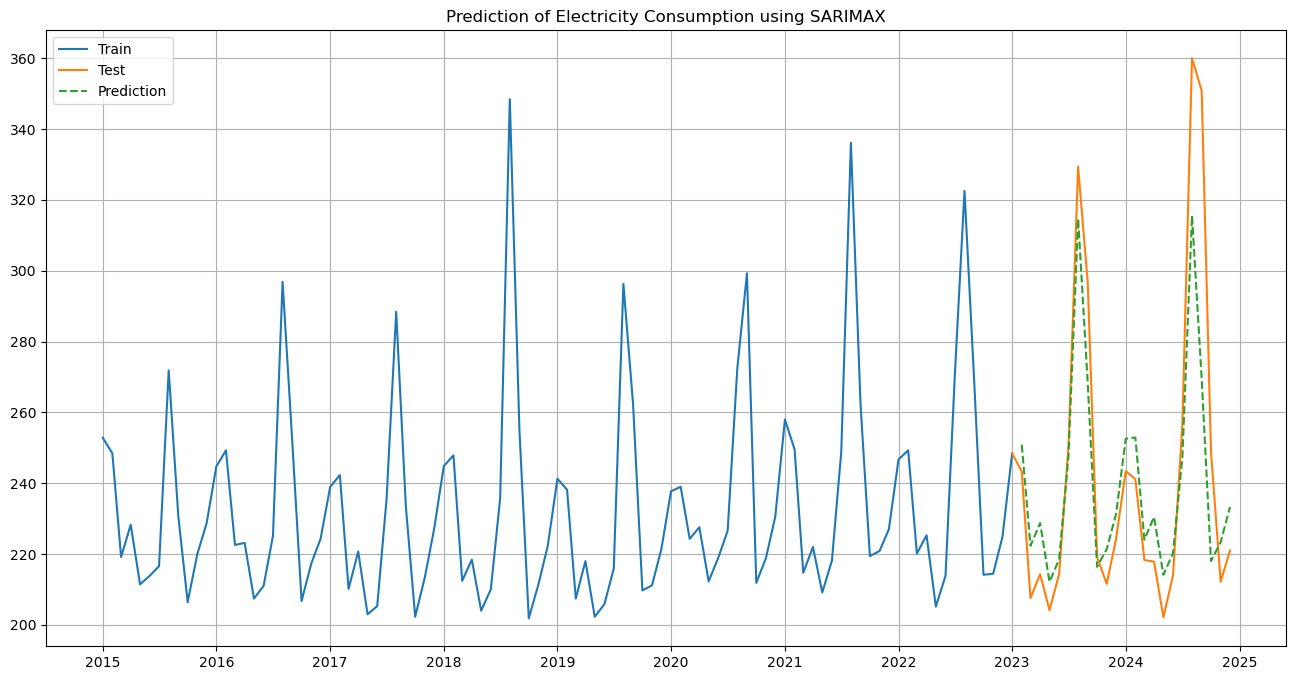

In [80]:
# Forecast
plt.figure(figsize=(16, 8))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(y_pred[:-1], label='Prediction', linestyle='--')
plt.legend()
plt.title("Prediction of Electricity Consumption using SARIMAX")
plt.grid()
plt.show()